In [61]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.signal import find_peaks
import scipy

from music import *

In [2]:
# Constants
radius = 4
thetas = np.array([0.2, np.pi / 2]) # in radians (should be in [0, pi/2])
source_locations = np.array([4 * np.array([np.cos(t), np.sin(t)]) for t in thetas])
n_sources = len(thetas)
w0 = np.pi / 4
n_mics = 20
mic_distance = 1
wavelength = 1
noise_var = 0.5
fs = 1
n_samples = 100

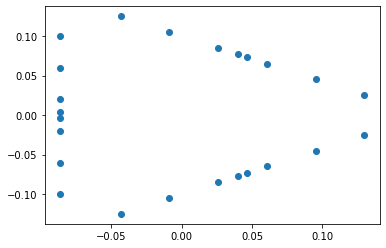

In [3]:
import json

with open('../music_doa/last_year/protocol.json') as json_file:  
    protocol = json.load(json_file)
    
microphone_3D_locations = np.array(protocol['geometry']['microphones']['locations'])
top_mics = np.isclose(microphone_3D_locations[:,2], 0.06123724)
microphone_2D_locations = microphone_3D_locations[top_mics, :2]

plt.scatter(microphone_2D_locations[:, 0], microphone_2D_locations[:, 1])
plt.show()

## Crafting the signal

In [4]:
def narrowband_signal(k, w0):    
    def helper(t):
        # Use a hash as a seed to ensure that if (k1, t1) = (k2, t2), then we give the exact result
        rng = np.random.RandomState(hash((k, t)) & 0xffffffff)
        return rng.randn() * np.exp(-1j * w0 * t)
    return helper

def received_signal(source_locations, narrowband_signals, mic_coords, noise_var=0, wavelength=1):
    def helper(t):
        signal = 0
        for source_coords, narrowband in zip(source_locations, narrowband_signals):
            atheta = np.exp(1j * 2 * np.pi / wavelength * np.linalg.norm(mic_coords - source_coords))
            signal += narrowband(t) * atheta
            
        return signal + np.random.normal(size=2, scale=noise_var).view(np.complex128)[0]
    
    return helper

In [5]:
narrowband_signals = [narrowband_signal(k, w0) for k in range(n_sources)]
received_signals = [received_signal(source_locations, narrowband_signals, mic_coords, noise_var=noise_var, wavelength=wavelength) for mic_coords in microphone_2D_locations]

sampled_received = np.zeros((len(received_signals), n_samples), dtype=np.csingle)

for i, received in enumerate(received_signals):
    for j in range(n_samples):
        sampled_received[i, j] = received(j / fs)

sampled_received.shape

(24, 100)

In [20]:
from scipy.signal.windows import gaussian
from scipy.signal import ShortTimeFFT

x = np.random.randn(1000)
n_intervals=4

freq, time_intervals, stft = scipy.signal.stft(x, nperseg=100)

In [21]:
stft.shape

(51, 21)

In [22]:
freq

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 ])

In [23]:
time_intervals

array([   0.,   50.,  100.,  150.,  200.,  250.,  300.,  350.,  400.,
        450.,  500.,  550.,  600.,  650.,  700.,  750.,  800.,  850.,
        900.,  950., 1000.])

In [39]:
temp = np.argwhere((0.2 <= freq) & (freq <= 0.3)).flatten()
temp

array([20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], dtype=int64)

In [42]:
stft[temp].shape

(11, 21)

In [24]:
freq.shape

(51,)

In [25]:
time_intervals.shape

(21,)

In [47]:
np.arange(0, 10).reshape((2, 5))

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])

In [59]:
res = 
res

array([[[ 0,  0,  0,  0,  0],
        [ 0,  1,  2,  3,  4],
        [ 0,  2,  4,  6,  8],
        [ 0,  3,  6,  9, 12],
        [ 0,  4,  8, 12, 16]],

       [[25, 30, 35, 40, 45],
        [30, 36, 42, 48, 54],
        [35, 42, 49, 56, 63],
        [40, 48, 56, 64, 72],
        [45, 54, 63, 72, 81]]])

In [13]:
def covariance_with_intervals(samples, n_intervals):
    samples = samples[:, : samples.shape[1] // n_intervals * n_intervals] # Cut samples in the last interval
    
    n_mics = samples.shape[0]
    reshaped = samples.reshape((n_mics, n_intervals, -1)).transpose((1, 0, 2))
    n_samples_per_interval = reshaped.shape[2]
    
    sampled_covariances = []
    for sampled in reshaped:
        sampled_covariances.append(sampled @ sampled.conj().T / n_samples_per_interval)

    return np.mean(sampled_covariances, axis=0)


def music(samples, n_sources, n_intervals=1):
    M = len(samples)
    
    samples = (samples.T - samples.mean(axis=1).T).T

    print('Samples shape:', samples.shape)
    # covariance = samples @ samples.conj().T / M
    covariance = covariance_with_intervals(samples, n_intervals)
    print("Covariance shape:", covariance.shape)
    print("Determinant of covariance:", np.linalg.det(covariance))
    
    eigenvalues, eigenvectors = np.linalg.eigh(covariance)
    
    # Decompose signal and noise
    # Assumption : the noise has the smallest eigenvalues
    signal_eigenvalues, signal_eigenvectors = eigenvalues[-n_sources :], eigenvectors[:, -n_sources :]
    noise_eigenvalues, noise_eigenvectors = eigenvalues[: -n_sources], eigenvectors[:, : -n_sources]
    
    return signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors


def general_spectrum_function(noise_eigenvectors, mic_locations, wavelength):
    M = noise_eigenvectors.shape[0]
    def helper(theta):
        a = np.array([np.cos(theta), np.sin(theta)])
        atheta = np.exp(-1j * 2 * np.pi / wavelength * np.dot(mic_locations, a))
        temp = atheta.conj() @ noise_eigenvectors
        
        return 1 / np.linalg.norm(temp)**2
    
    return helper

In [ ]:
music_with_frequency

Samples shape: (24, 100)
Covariance shape: (24, 24)
Determinant of covariance: (2.3043024e-06-4.0848894e-13j)


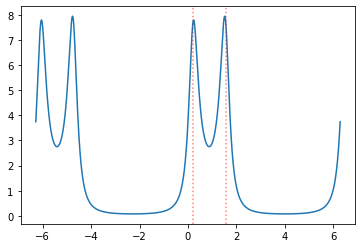

In [14]:
signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(sampled_received, n_sources, n_intervals=5)
spectrum = general_spectrum_function(noise_eigenvectors, microphone_2D_locations, wavelength)

X = np.linspace(-2 * np.pi, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in thetas:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

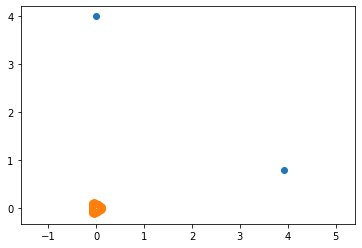

In [15]:
plt.scatter(*source_locations.T)
plt.scatter(*microphone_2D_locations.T)
plt.axis('equal')
plt.show()

In [16]:
def extract_frequencies(spectrum, n_sources, input_range, resolution=10000):
    X = np.linspace(input_range[0], input_range[1], resolution)
    Y = np.array([spectrum(x) for x in X])
    
    threshold = np.sort(Y)[int(0.8 * resolution)]
    
    peak_indices, _ = find_peaks(Y, threshold)
    indices = np.argsort(Y[peak_indices])[-n_sources:]  # Sort peak indices by y value and take the top num_peaks    
    estimated_freq = peak_indices[indices]
    
    return (estimated_freq / resolution) * (input_range[1] - input_range[0]) + input_range[0]

In [17]:
estimated_thetas = extract_frequencies(spectrum, n_sources, [0, np.pi])
estimated_thetas

array([0.23310617, 1.51581846])

## PyRoomAccoustics test

In this section we will test our pipeline with the pra module

In [63]:
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython

In [65]:
fs, data = wavfile.read('res/arctic_a0010.wav')
data_variance = np.var(data)
IPython.display.Audio(data, rate=fs)

In [66]:
c = 343.    # speed of sound
# fs = 16000  # sampling frequency
nfft = 256  # FFT size
freq_range = [300, 3500]
radius=4e-1
mic_distance = 4e-1
start = 4
n_mics = 6

snr_db = 2
distance = 3.  # meters idk wtf is happening
sigma2 = 1 * data_variance

### Creating the room

(<Figure size 432x288 with 1 Axes>, <Axes: >)

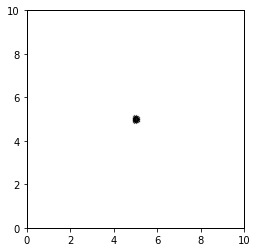

In [67]:
room_dim = np.r_[10.,10.]
aroom = pra.ShoeBox(room_dim, fs=fs, max_order=0, sigma2_awgn=sigma2)

# Adding the microphones

mics_coords = (microphone_2D_locations + room_dim / 2).T
aroom.add_microphone_array(pra.MicrophoneArray(mics_coords, aroom.fs))

# echo = pra.circular_2D_array(center=room_dim/2, M=6, phi0=0, radius=37.5e-3)
# echo = np.concatenate((echo, np.array(room_dim/2, ndmin=2).T), axis=1)
# aroom.add_microphone_array(pra.MicrophoneArray(echo, aroom.fs))

aroom.plot()

(<Figure size 432x288 with 1 Axes>, <Axes: >)

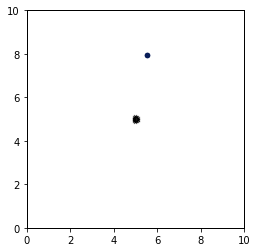

In [68]:
# Add sources of 1 second duration
azimuth = np.array([80]) / 180. * np.pi

rng = np.random.RandomState(23)
duration_samples = 10000

for ang in azimuth:
    random_phase = np.random.uniform(0, 2 * np.pi)
    source_location = room_dim / 2 + distance * np.r_[np.cos(ang), np.sin(ang)]
    aroom.add_source(source_location, signal=data)
    
# Run the simulation
aroom.simulate()
aroom.plot()

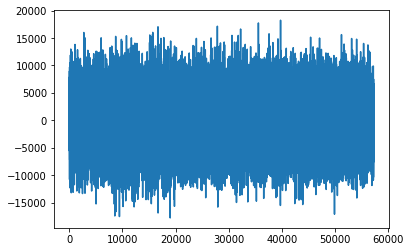

In [69]:
plt.plot(aroom.mic_array.signals[0])
plt.show()

In [71]:
IPython.display.Audio(aroom.mic_array.signals[0], rate=fs)

Samples shape: (24, 57268)
Covariance shape: (24, 24)


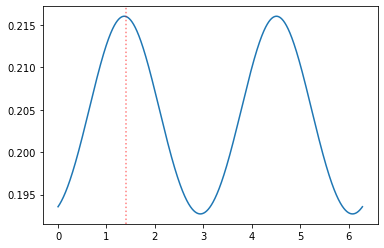

In [74]:
n_sources = len(azimuth)

signal_eigenvalues, signal_eigenvectors, noise_eigenvalues, noise_eigenvectors = music(aroom.mic_array.signals, n_sources)
spectrum = general_spectrum_function(noise_eigenvectors, mics_coords.T, wavelength)

X = np.linspace(0, 2 * np.pi, 10000)
Y = [spectrum(x) for x in X]

plt.plot(X, Y)
for theta in azimuth:
    plt.axvline(x=theta, color='red', linestyle=':', alpha=0.5)
plt.show()

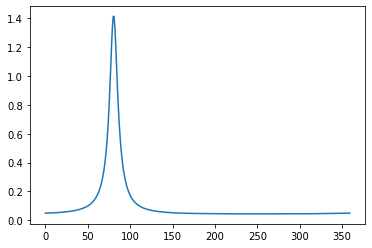

In [75]:
# Implementation of MUSIC by PRA
X = pra.transform.stft.analysis(aroom.mic_array.signals.T, nfft, nfft // 2)
X = X.transpose([2, 1, 0])
doa = pra.doa.algorithms["MUSIC"](mics_coords, fs, nfft, c=c, num_src=n_sources, max_four=4)
doa.locate_sources(X, freq_range=freq_range)
spatial_resp = doa.grid.values

plt.plot(spatial_resp)